<a href="https://colab.research.google.com/github/mayurrrrr18/univariate-time-series/blob/main/General_stores_monthly_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial Data Information:
     Month     Sales
0  2020-01  20745.07
1  2020-02  21962.10
2  2020-03  26310.52
3  2020-04  29793.02
4  2020-05  30326.74

Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   60 non-null     object 
 1   Sales   60 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB
None


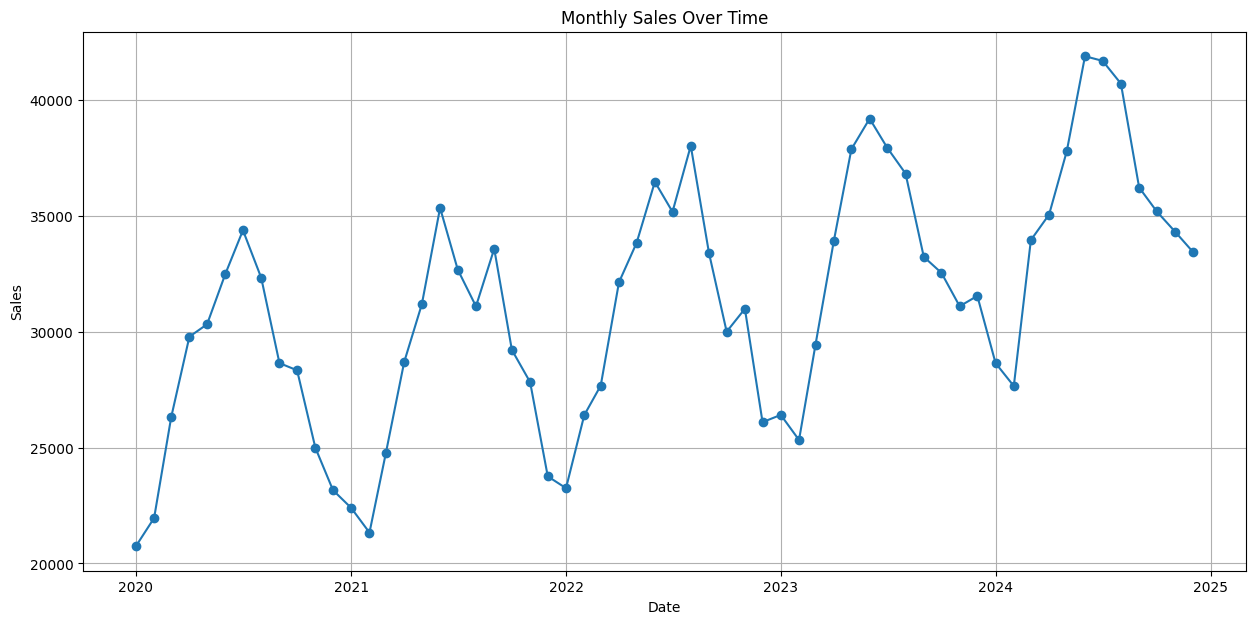


--- ADF test on the original data ---
ADF Statistic: 1.0421929427306915
p-value: 0.9946917734038903
Critical Values:
	1%: -3.5714715250448363
	5%: -2.922629480573571
	10%: -2.5993358475635153

Conclusion: The series is likely non-stationary. Differencing is required.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Load the dataset
file_path = '/content/store_monthly_sales.csv'
df = pd.read_csv(file_path)

# Display initial information about the data
print("Initial Data Information:")
print(df.head())
print("\nData Types:")
print(df.info())

# Data Preparation - Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Drop any potential NaN values that may be introduced during a transformation
df.dropna(inplace=True)

# Visualize the time series data
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Sales'], marker='o')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# Check for stationarity using the Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print("\nConclusion: The series is likely stationary.")
    else:
        print("\nConclusion: The series is likely non-stationary. Differencing is required.")

print("\n--- ADF test on the original data ---")
adf_test(df['Sales'])

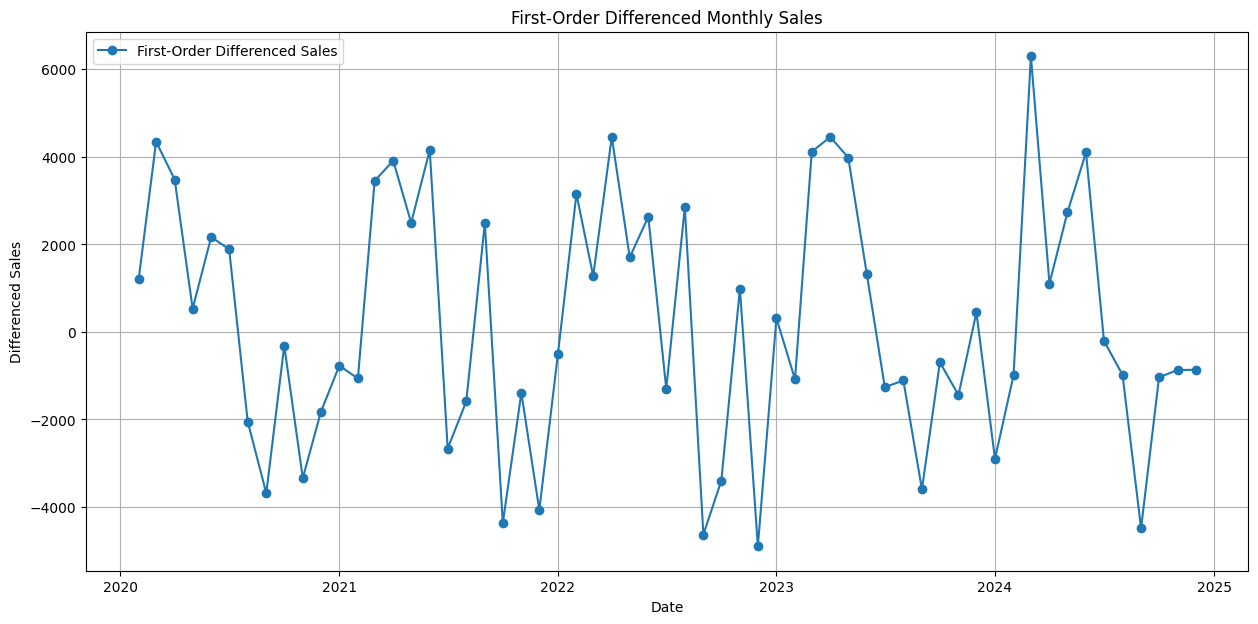


--- ADF test on the differenced data ---
ADF Statistic: -5.12010770287836
p-value: 1.2770900302833394e-05
Critical Values:
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064

Conclusion: The series is likely stationary.

--- ACF and PACF plots for differenced data ---


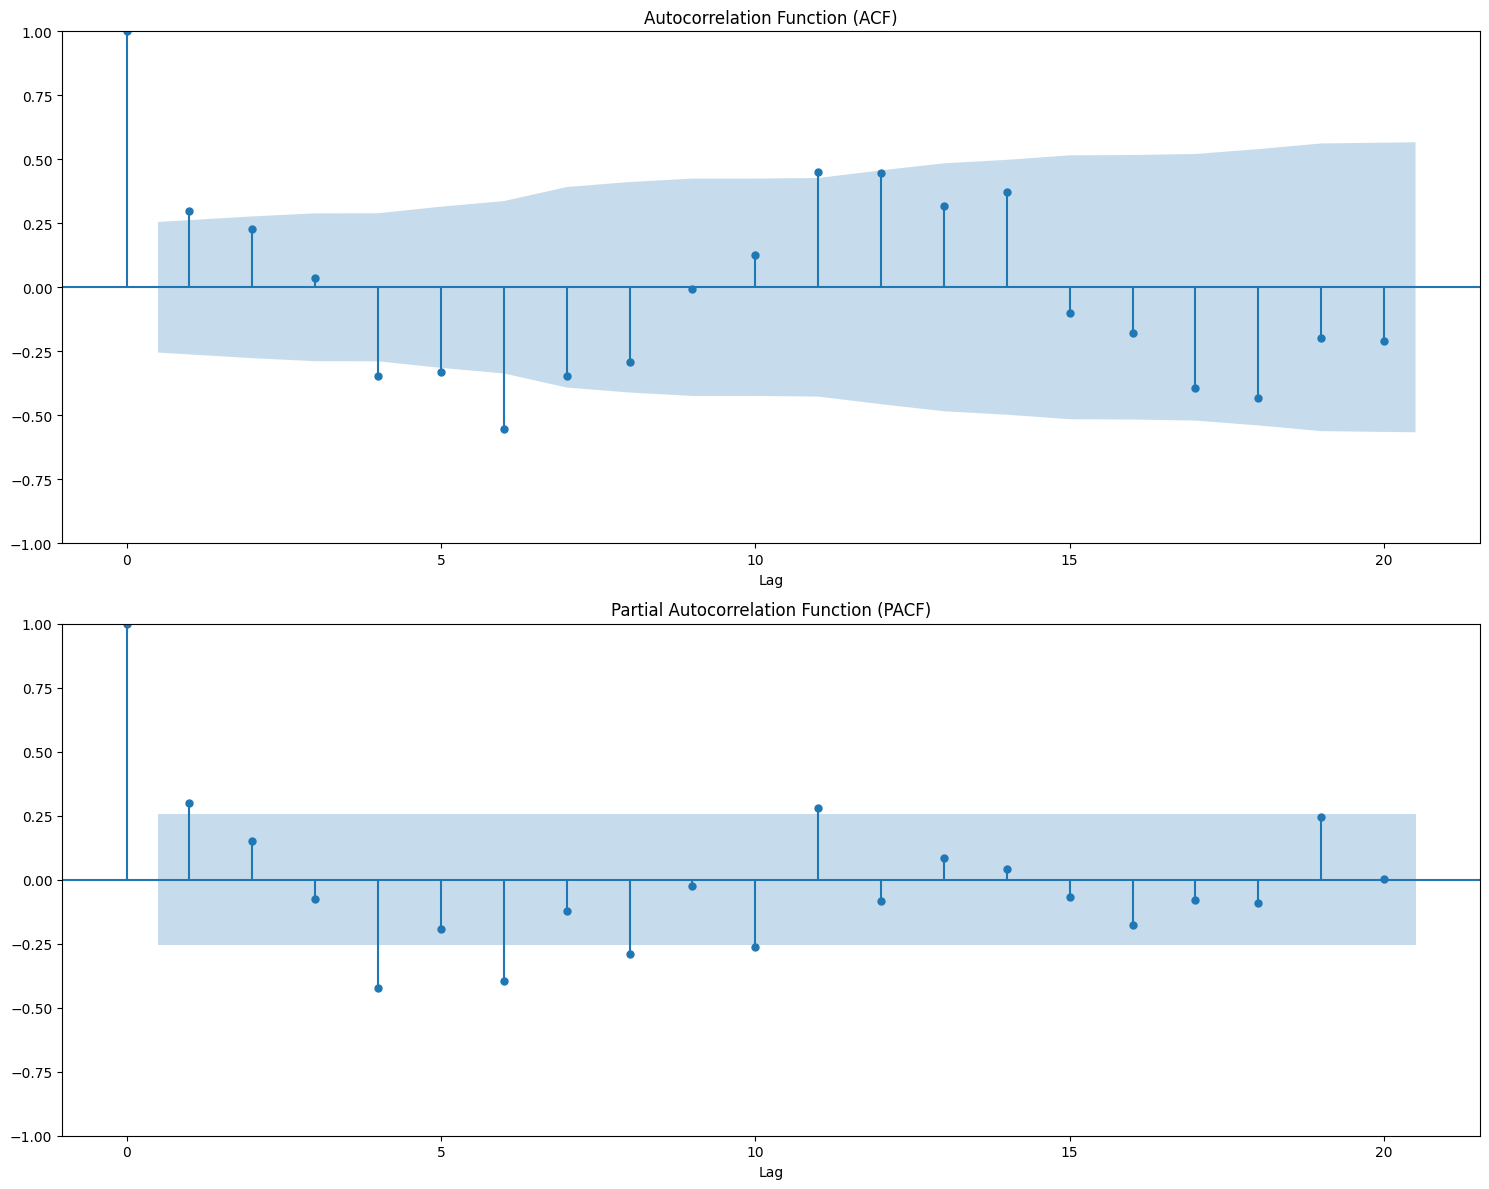

In [4]:
# Perform first-order differencing
df['Sales_Diff'] = df['Sales'].diff()

# Visualize the differenced data
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Sales_Diff'], marker='o', label='First-Order Differenced Sales')
plt.title('First-Order Differenced Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Differenced Sales')
plt.grid(True)
plt.legend()
plt.show()

# Run the ADF test on the differenced data
print("\n--- ADF test on the differenced data ---")
adf_test(df['Sales_Diff'].dropna())

# Step 3: Identify AR(p) and MA(q) parameters using ACF and PACF plots
print("\n--- ACF and PACF plots for differenced data ---")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
plot_acf(df['Sales_Diff'].dropna(), ax=ax1, lags=20, title='Autocorrelation Function (ACF)')
plot_pacf(df['Sales_Diff'].dropna(), ax=ax2, lags=20, title='Partial Autocorrelation Function (PACF)')
ax1.set_xlabel('Lag')
ax2.set_xlabel('Lag')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -436.615
Date:                Tue, 05 Aug 2025   AIC                            879.229
Time:                        11:35:26   BIC                            884.780
Sample:                    01-01-2020   HQIC                           881.318
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5582      0.377      1.480      0.139      -0.181       1.297
ma.L1         -0.3657      0.430     -0.850      0.395      -1.209       0.478
sigma2      7.008e+06   8.69e-09   8.06e+14      0.0

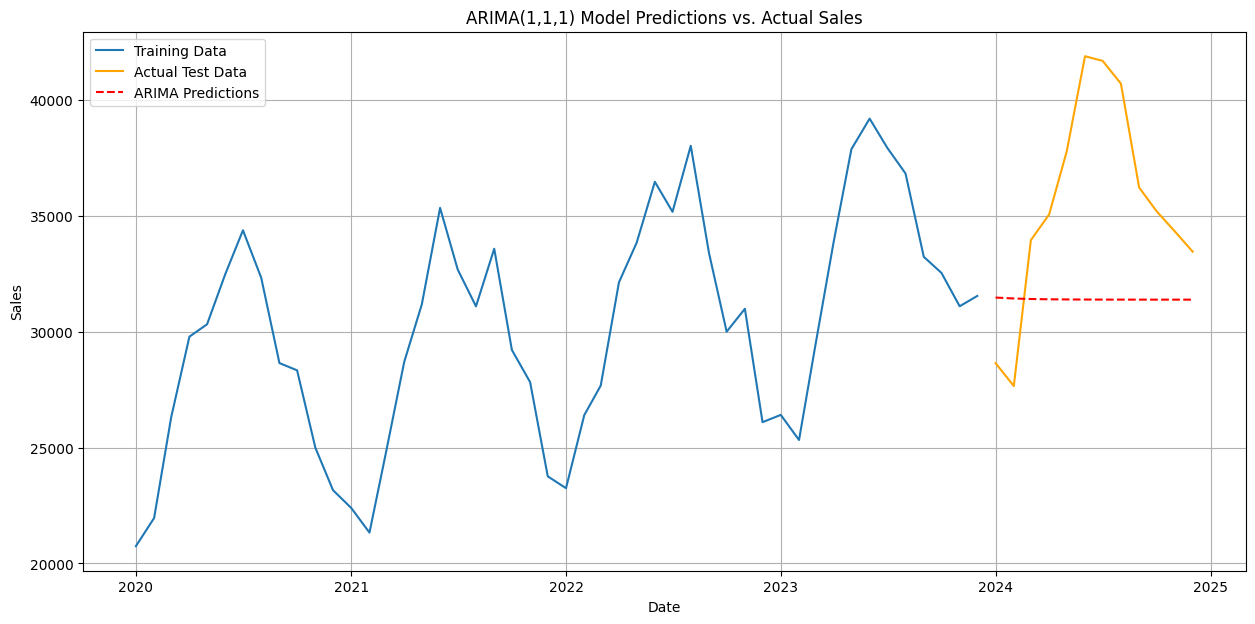

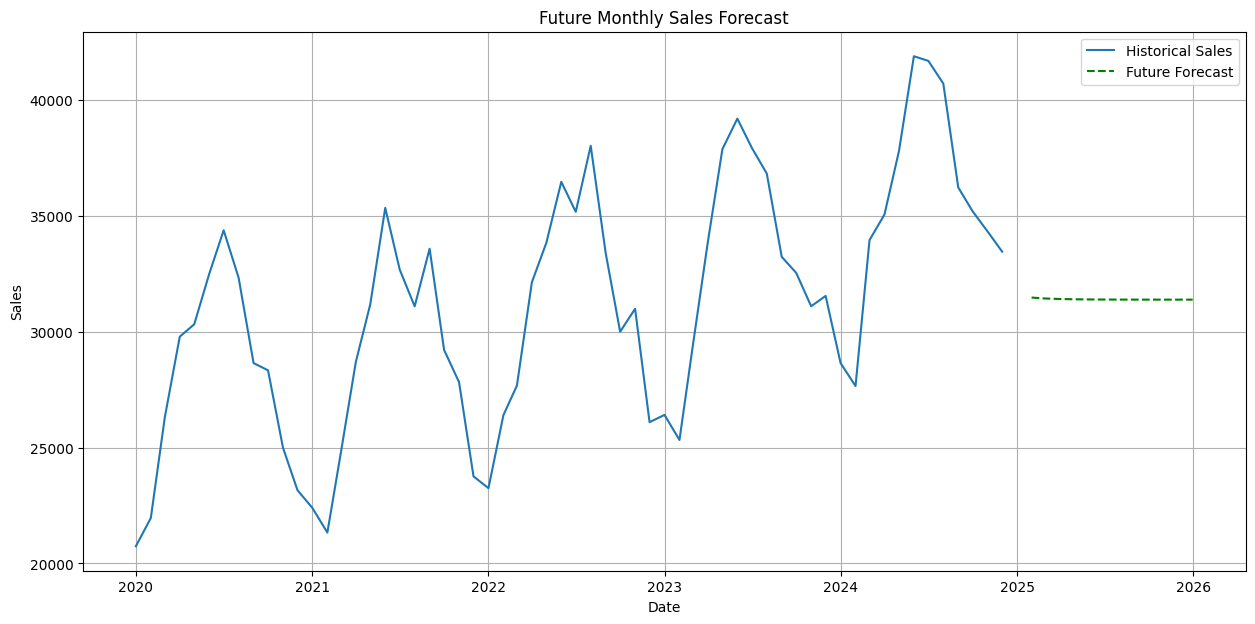

In [6]:
# Step 4: Model Building and Evaluation
# Split the data into a training and testing set
train_size = int(len(df) * 0.8)
train, test = df['Sales'].iloc[:train_size], df['Sales'].iloc[train_size:]

# Fit the ARIMA(1,1,1) model
# The order is (p, d, q)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

# Make predictions on the test set
test_predictions = model_fit.forecast(steps=len(test))

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(test, test_predictions))
print(f"\nRoot Mean Squared Error (RMSE) on test set: {rmse:.2f}")

# Plotting the training data, actual test data, and the predictions
plt.figure(figsize=(15, 7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Test Data', color='orange')
plt.plot(test.index, test_predictions, label='ARIMA Predictions', color='red', linestyle='--')
plt.title('ARIMA(1,1,1) Model Predictions vs. Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Forecasting future sales
future_forecast_steps = 12
future_forecast = model_fit.forecast(steps=future_forecast_steps)

# Create a new index for the forecasted data
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_forecast_steps + 1, freq='ME')[1:]

# Plot the historical data and the future forecast
plt.figure(figsize=(15, 7))
plt.plot(df['Sales'], label='Historical Sales')
plt.plot(future_dates, future_forecast, label='Future Forecast', color='green', linestyle='--')
plt.title('Future Monthly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()